In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
import tensorflow_probability as tfp

import shutil, os, sys, io, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from tensor_board_logger import TensorBoardLogger
from layer_visualizer import LayerVisualizer

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

In [2]:
from collections import OrderedDict
ds = tfp.distributions
slim = tf.contrib.slim

# import moviepy.editor as mpyでエラーがでるため使用せず。
# try:
#     from moviepy.video.io.bindings import mplfig_to_npimage
#     import moviepy.editor as mpy
#     generate_movie = True
# except:
#     print("Warning: moviepy not found.")
generate_movie = False
    
from tensorflow.contrib import graph_editor

In [3]:
def sample_mog(batch_size, n_mixture=8, std=0.01, radius=1.0):
    thetas = np.linspace(0, 2 * np.pi, n_mixture)
    xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    # MultivariateNormalDiag呼び出しでエラー。ただし現状numpy内部でnp.asscalar(a)をa.item()にswapしており実害なし。
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)
    # 半径1の円周上8点を中心とした8個の正規分布からbatch_size個の点をサンプリング

In [19]:
class GAN():
    def __init__(self):
        target_dir = './my_log_dir_toy1'
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)
        
        # ---------------------
        #  Parameter
        # ---------------------
        # self.unrolling_steps = 0
        self.n_critic = 5
        self.clip_value = 0.01
        
        self.img_dim = 2 #生成画像の次元
        self.latent_dim = 256 # Noiseの次元
        optimizer_disc = Adam(lr=1e-4, beta_1=0.5, epsilon=1e-8)
        optimizer_gen = Adam(lr=1e-3, beta_1=0.5, epsilon=1e-8)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = True       
        self.discriminator.compile(
                                   loss=self.wasserstein_loss,
                                   optimizer=optimizer_disc,
                                   metrics=['accuracy']
                                  )

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)
        
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
              
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
             
        self.combined.compile(
                              loss=self.wasserstein_loss,
                              optimizer=optimizer_gen,
                              metrics=['accuracy']
                             )
        
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(2,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                       ))
        # model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential()
        # model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(1,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                       ))
        # model.summary()
        img = Input(shape=(self.img_dim,))
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        frames = []
        np_samples = []

        # ---------------------
        #  Load the dataset
        # ---------------------
        X_train = tf.Session().run(sample_mog(60000))
        
        # Adversarial ground truths
        valid_1 = np.ones((batch_size, 1))
        fake_0 = - np.ones((batch_size, 1))
        valid = np.ones((batch_size, 1))
        fake = - np.ones((batch_size, 1))
        
        for epoch in tqdm(range(epochs+1)):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            for _ in range(self.n_critic):
                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx] # imgs = tf.expand_dims(imgs, axis=2)は今回不要

                # Generate a batch of new images            
                noise = np.random.randn(batch_size, self.latent_dim)
                gen_imgs = self.generator.predict(noise, steps=1)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(
                    imgs, valid
                )  # 単一バッチデータにつき一度の勾配更新を行う。
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Clip critic weights
                for l in self.discriminator.layers:
                    # discriminator各層の重さを取得し、範囲外の値を最小値、最大値に置換
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)
                    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.randn(batch_size, self.latent_dim)

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid_1)        

            # ---------------------
            #  Log
            # ---------------------                 
            logs = {'Discriminator/loss': d_loss[0], 'Generator/loss': g_loss[0], 'Generator/acc': g_loss[1]}
            histograms = {}
            for layer in self.generator.layers[1].layers:
                if 'conv' in layer.name or 'dense' in layer.name:
                    for i in range(len(layer.get_weights())):
                        name = layer.name + '/' + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch)
            
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f] [G loss: %f, G acc.: %.2f%%]" % (epoch, d_loss[0], g_loss[0], 100*g_loss[1])) 
                np_samples.append(np.vstack(gen_imgs)) # 縦方向(vertical)に連結
                xx = gen_imgs
                yy = imgs
                fig = figure(figsize=(5,5))
                scatter(xx[:, 0], xx[:, 1], edgecolor='none')
                scatter(yy[:, 0], yy[:, 1], c='g')
                axis('off')
                if generate_movie:
                    frames.append(mplfig_to_npimage(fig))
                show()

        return np_samples

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        name = str(epoch) + '.png'
        return fig, name
        # fig.savefig("images/%d.png" % epoch)
        # plt.close()

In [20]:
gan = GAN()

In [21]:
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


  0%|          | 0/100001 [00:00<?, ?it/s]

0 [D loss: 0.000026] [G loss: -0.000112, G acc.: 0.00%]


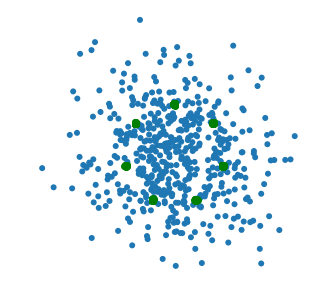

  5%|▍         | 5000/100001 [07:22<2:19:51, 11.32it/s]

5000 [D loss: 0.000020] [G loss: -0.000072, G acc.: 0.00%]


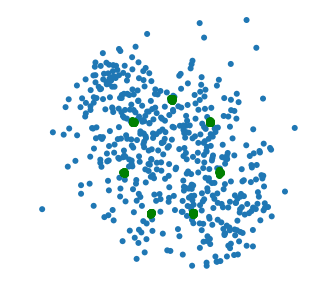

 10%|▉         | 10000/100001 [14:40<2:08:16, 11.69it/s]

10000 [D loss: 0.000005] [G loss: 0.000046, G acc.: 0.00%]


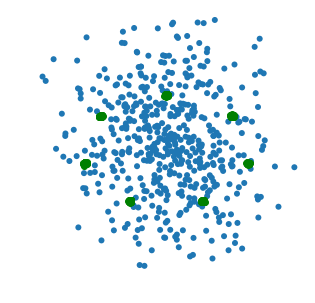

 15%|█▍        | 15000/100001 [21:59<2:13:16, 10.63it/s]

15000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


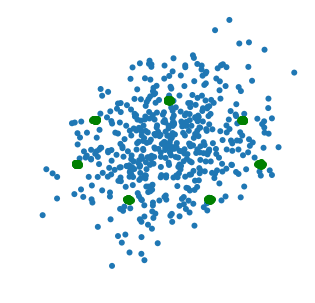

 20%|█▉        | 20000/100001 [29:29<2:58:00,  7.49it/s]

20000 [D loss: 0.000017] [G loss: -0.000073, G acc.: 0.00%]


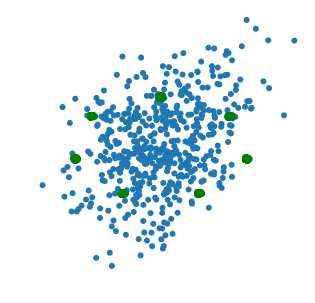

 25%|██▍       | 25000/100001 [41:00<2:42:59,  7.67it/s]

25000 [D loss: 0.000035] [G loss: -0.000206, G acc.: 0.00%]


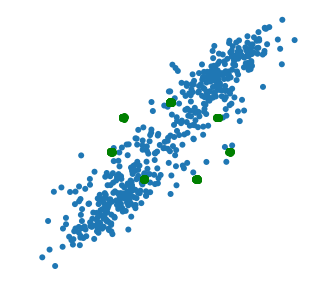

 30%|██▉       | 30000/100001 [53:05<2:33:04,  7.62it/s]

30000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


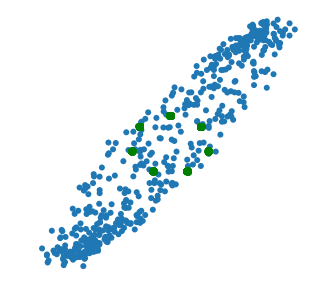

 35%|███▍      | 35000/100001 [1:04:28<2:23:41,  7.54it/s]

35000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


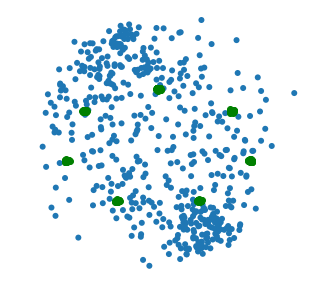

 40%|███▉      | 40000/100001 [1:15:54<2:05:44,  7.95it/s]

40000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


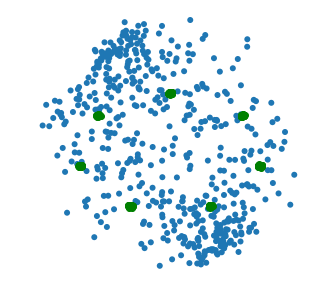

 45%|████▍     | 45000/100001 [1:27:16<2:03:01,  7.45it/s]

45000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


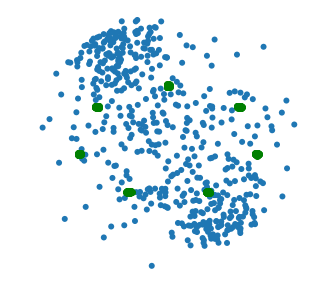

 50%|████▉     | 50000/100001 [1:38:38<1:49:34,  7.61it/s]

50000 [D loss: -0.000229] [G loss: 0.000415, G acc.: 0.00%]


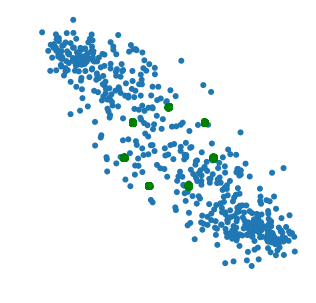

 55%|█████▍    | 55000/100001 [1:50:05<1:38:34,  7.61it/s]

55000 [D loss: 0.000022] [G loss: -0.000082, G acc.: 0.00%]


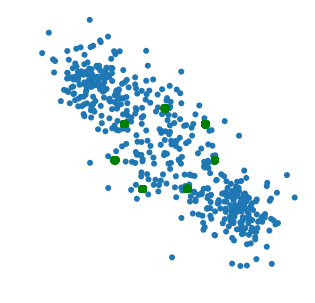

 60%|█████▉    | 60000/100001 [2:01:21<1:27:08,  7.65it/s]

60000 [D loss: 0.000017] [G loss: -0.000075, G acc.: 0.00%]


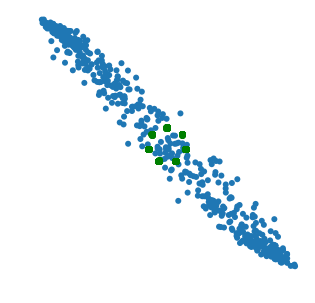

 65%|██████▍   | 65000/100001 [2:12:43<1:16:40,  7.61it/s]

65000 [D loss: -0.000001] [G loss: -0.000123, G acc.: 0.00%]


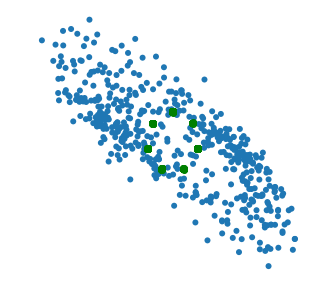

 70%|██████▉   | 70000/100001 [2:24:10<1:06:03,  7.57it/s]

70000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


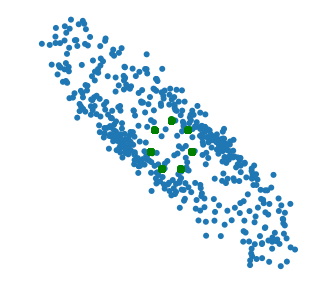

 75%|███████▍  | 75000/100001 [2:35:28<53:50,  7.74it/s]

75000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


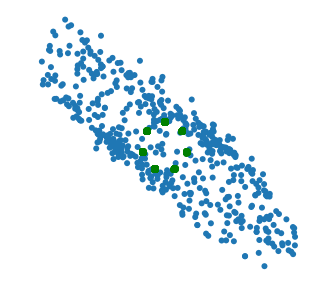

 80%|███████▉  | 80000/100001 [2:46:38<47:51,  6.97it/s]

80000 [D loss: 0.000017] [G loss: -0.000073, G acc.: 0.00%]


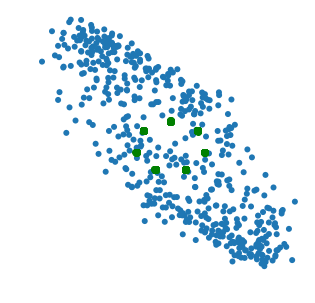

 85%|████████▍ | 85000/100001 [2:57:56<32:15,  7.75it/s]

85000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


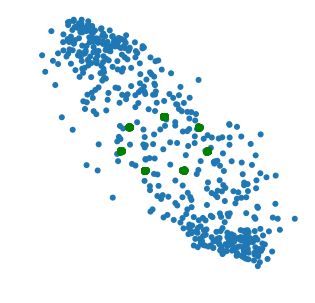

 90%|████████▉ | 90000/100001 [3:09:18<21:48,  7.64it/s]

90000 [D loss: 0.000218] [G loss: 0.000074, G acc.: 0.00%]


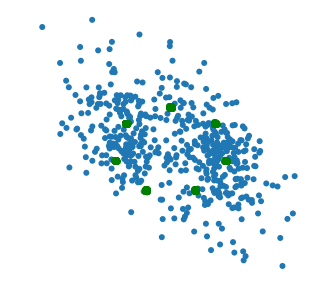

 95%|█████████▍| 95000/100001 [3:20:38<10:55,  7.63it/s]

95000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


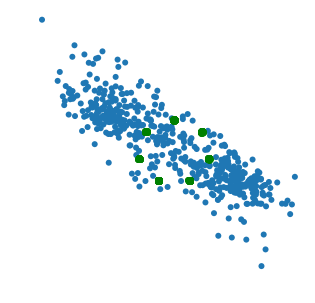

100%|█████████▉| 100000/100001 [3:31:58<00:00,  6.39it/s]

100000 [D loss: 0.000017] [G loss: -0.000074, G acc.: 0.00%]


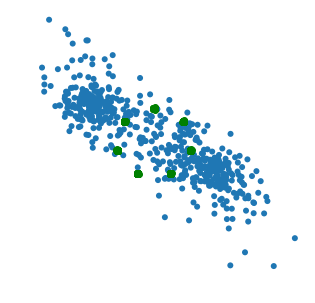

100%|██████████| 100001/100001 [3:31:58<00:00,  4.87it/s]


In [22]:
%pylab inline
np_samples = gan.train(epochs=100000, batch_size=512, sample_interval=5000)

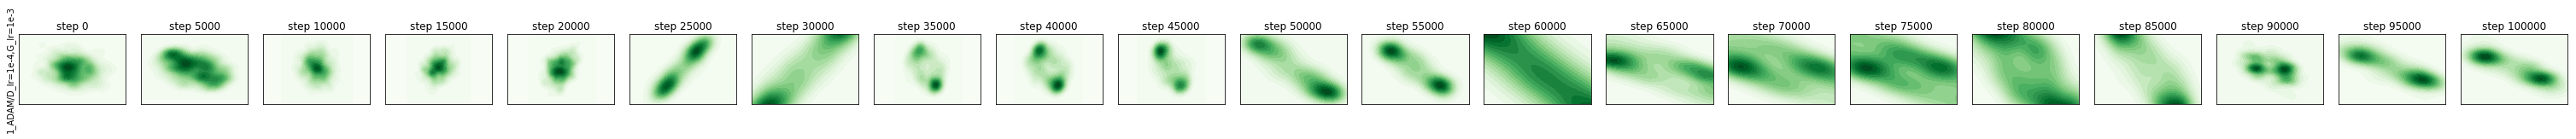

In [25]:
import seaborn as sns
np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-3, 3]]*2)
    ax2.set_facecolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*5000))
ax.set_ylabel('1_ADAM/D_lr=1e-4,G_lr=1e-3')
gcf().tight_layout()